<img src="http://www.cidaen.es/assets/img/mCIDaeNnb.png" alt="Logo CiDAEN" align="right">




<br><br><br>
<h2><font color="#00586D" size=4>Trabajo Fin de Máster</font></h2>



<h1><font color="#00586D" size=5>Análisis del sentimiento en redes sociales</font></h1>
<h2>COVID-19</h2>

<br><br><br>
<div style="text-align: right">
<font color="#00586D" size=3>Tomás Pérez Campayo</font><br>
<font color="#00586D" size=3>Máster en Ciencia de Datos e Ingeniería de Datos en la Nube</font><br>
<font color="#00586D" size=3>Universidad de Castilla-La Mancha</font>

</div>

En esta libreta se presentan los resultados obtenidos del procesamiento de la información obtenida de la red social Tweeter asi como los datos descargados del Centro Nacional de Epidemiología.

Una vez analizados por separado, se intenta ver si hay algún tipo de correlación entre ambos sets de datos.

####  <font color="#00586D">Datos obtenidos de https://cnecovid.isciii.es/covid19/#documentaci%C3%B3n-y-datos</font>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import boto3

df = pd.read_csv("./Data/casos_hosp_uci_def_sexo_edad_provres.csv")

Aquí vemos la estructura del dataset. Los datos vienen separados por **Fecha / Provincia / Sexo / Grupo de edad**.

Para nuestro análisis agruparemos únicamente por fecha para obtener totales (número de casos, número hospitalizados, número de ingresados UCI y número de defunciones) por día.

In [2]:
df.head()

,provincia_iso,sexo,grupo_edad,fecha,num_casos,num_hosp,num_uci,num_def
0,A,H,0-9,2020-01-01,0,0,0,0
1,A,H,10-19,2020-01-01,0,0,0,0
2,A,H,20-29,2020-01-01,0,0,0,0
3,A,H,30-39,2020-01-01,0,0,0,0
4,A,H,40-49,2020-01-01,0,0,0,0


Nos quedamos únicamente con las columnas que nos hacen falta (fecha, num_casos, num_hosp, num_uci y num_def). Por otro lado, si comprobamos el tipo de dato para cada columna, nos damos cuenta que el campo fecha lo reconoce como un string en lugar de Datetime.

In [3]:
df_covid = df[['fecha','num_casos', 'num_hosp', 'num_uci', 'num_def']]
df_covid.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 793410 entries, 0 to 793409
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   fecha      793410 non-null  object
 1   num_casos  793410 non-null  int64 
 2   num_hosp   793410 non-null  int64 
 3   num_uci    793410 non-null  int64 
 4   num_def    793410 non-null  int64 
dtypes: int64(4), object(1)
memory usage: 30.3+ MB


Ahora transformamos el campo fecha a objetos Datetime 

In [4]:
df_covid['fecha'] = pd.to_datetime(df_covid['fecha'], format='%Y/%m/%d')

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [5]:
df_covid

,fecha,num_casos,num_hosp,num_uci,num_def
0,2020-01-01,0,0,0,0
1,2020-01-01,0,0,0,0
2,2020-01-01,0,0,0,0
3,2020-01-01,0,0,0,0
4,2020-01-01,0,0,0,0
...,...,...,...,...,...
793405,2021-05-13,0,0,0,0
793406,2021-05-13,0,0,0,0
793407,2021-05-13,0,0,0,0
793408,2021-05-13,0,0,0,0


El siguiente paso es filtrar por la fecha a partir de la cual disponemos de datos de análisis del sentimiento en AWS para luego realizar una comparativa.

In [6]:
df_covid = df_covid[df_covid['fecha'] >= '2021-03-15']
df_covid.head()

,fecha,num_casos,num_hosp,num_uci,num_def
698010,2021-03-15,0,0,0,0
698011,2021-03-15,2,1,0,0
698012,2021-03-15,0,0,0,0
698013,2021-03-15,3,0,0,0
698014,2021-03-15,1,0,0,0


Agrupamos y sumamos totales por fecha

In [7]:
df_covid_grouped = df_covid.groupby('fecha').sum()
df_covid_grouped.head()

,num_casos,num_hosp,num_uci,num_def
fecha,,,,
2021-03-15,5422,445,52,93
2021-03-16,5984,426,61,102
2021-03-17,5704,465,57,87
2021-03-18,6274,424,53,65
2021-03-19,4575,389,48,61


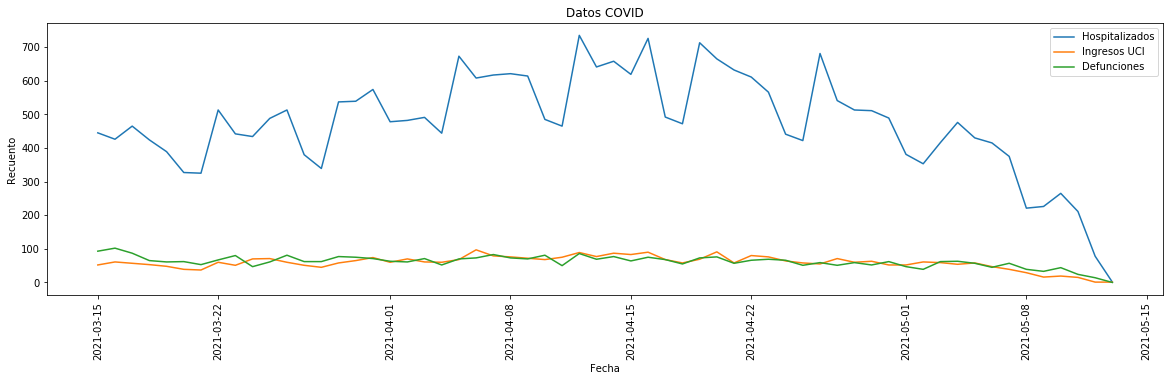

In [8]:
plt.figure(figsize=(20,5))

plt.xticks(rotation=90)

#plt.plot(df_covid_grouped.index, df_covid_grouped['num_casos'], label = "Casos")
plt.plot(df_covid_grouped.index, df_covid_grouped['num_hosp'], label = "Hospitalizados")
plt.plot(df_covid_grouped.index, df_covid_grouped['num_uci'], label = "Ingresos UCI")
plt.plot(df_covid_grouped.index, df_covid_grouped['num_def'], label = "Defunciones")

plt.xlabel('Fecha')
plt.ylabel('Recuento')

plt.title('Datos COVID')
# show a legend on the plot
plt.legend()
# Display a figure.
plt.show()

####  <font color="#00586D">Datos obtenidos de la red social Tweeter</font>

El primer paso es establecer conexión con el servicio AWS a través de la librería boto3.

Creamos el objeto cliente para dynamodb e instanciamos las tablas que vamos a consultar:

    - Tabla tweets: [tweet_date, tweet_id, tweet_text, polarity, sentiment]
    - Tabla tweets_statistics: [TweetDate, positive, negative, mixed, neutral]

In [9]:
#Servicio DynamoDb
dynamodb_client = boto3.resource('dynamodb', region_name='us-east-1')
tweets_table = dynamodb_client.Table('tweets')
tweets_statistics_table = dynamodb_client.Table('tweets_statistics')

Realizamos un scan de la tabla `tweets` para descargar todos los datos de la tabla

In [10]:
data = tweets_table.scan()
df_tweets = pd.DataFrame.from_dict(data['Items'])
df_tweets

,polarity,tweet_id,sentiment,tweet_date,tweet_text
0,-0.5779223185963928699493408203125,137768230066259968,NEGATIVE,01/04/2021,ltimos 130 dasCasos covid sin sancin ni comuni...
1,-0.3455162681639194488525390625,137768230082623078,NEUTRAL,01/04/2021,Colombia reporta 8646 nuevos casos de Covid19 ...
2,0.02471891604363918304443359375,137768230236552806,NEUTRAL,01/04/2021,El 591 de la poblacin espaola ha recibido la v...
3,-0.0156670920550823211669921875,137768230242415411,NEUTRAL,01/04/2021,LTIMAHORA Cardenal Baltazar Porras anunci este...
4,-0.02831505867652595043182373046875,137768230247034061,NEUTRAL,01/04/2021,Magallanes hoy reporta 28 casos nuevos de Covi...
...,...,...,...,...,...
3913,0.0426206330885179340839385986328125,137297169815745333,NEUTRAL,19/03/2021,Laboratorio para covid19 en Maiqueta se cre en...
3914,-0.251605871133506298065185546875,137297169850553549,NEUTRAL,19/03/2021,Ms precaucin En el reporte de las ltimas 24 ho...
3915,-0.02550903148949146270751953125,137297169913047040,NEUTRAL,19/03/2021,Estos es lo que ha revelado un reciente estudio
3916,-0.02550903148949146270751953125,137297170554358170,NEUTRAL,19/03/2021,Estos es lo que ha revelado un reciente estudio


Comentando / descomentando esta línea de código podemos sacar las gráficas de todo el set de datos (positivos, negativos, mixtos, neutros) o únicamente teniendo en cuenta los tweets clasificados como positivos y negativos

In [11]:
# Solo teniendo en cuenta los clasificados como positivos y negativos (dejamos fuera NEUTROS y MIXTOS)
#df_tweets = df_tweets[(df_tweets['sentiment'] == 'NEGATIVE') | (df_tweets['sentiment'] == 'POSITIVE')]

In [12]:
df_tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3918 entries, 0 to 3917
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   polarity    3918 non-null   object
 1   tweet_id    3918 non-null   object
 2   sentiment   3918 non-null   object
 3   tweet_date  3918 non-null   object
 4   tweet_text  3918 non-null   object
dtypes: object(5)
memory usage: 153.2+ KB


Como podemos observar en la celda de arriba, la polaridad la reconoce como un string por lo que para poder opear con ella la transformamos en un float. Igualmente, la columna tweet_date la transformaremos en un objeto datetime ya que también nos viene como un string.

In [13]:
df_tweets['polarity'] = df_tweets['polarity'].astype(float)

In [14]:
df_tweets['tweet_date'] = pd.to_datetime(df_tweets['tweet_date'], format='%d/%m/%Y')

In [15]:
df_tweets

,polarity,tweet_id,sentiment,tweet_date,tweet_text
0,-0.577922,137768230066259968,NEGATIVE,2021-04-01,ltimos 130 dasCasos covid sin sancin ni comuni...
1,-0.345516,137768230082623078,NEUTRAL,2021-04-01,Colombia reporta 8646 nuevos casos de Covid19 ...
2,0.024719,137768230236552806,NEUTRAL,2021-04-01,El 591 de la poblacin espaola ha recibido la v...
3,-0.015667,137768230242415411,NEUTRAL,2021-04-01,LTIMAHORA Cardenal Baltazar Porras anunci este...
4,-0.028315,137768230247034061,NEUTRAL,2021-04-01,Magallanes hoy reporta 28 casos nuevos de Covi...
...,...,...,...,...,...
3913,0.042621,137297169815745333,NEUTRAL,2021-03-19,Laboratorio para covid19 en Maiqueta se cre en...
3914,-0.251606,137297169850553549,NEUTRAL,2021-03-19,Ms precaucin En el reporte de las ltimas 24 ho...
3915,-0.025509,137297169913047040,NEUTRAL,2021-03-19,Estos es lo que ha revelado un reciente estudio
3916,-0.025509,137297170554358170,NEUTRAL,2021-03-19,Estos es lo que ha revelado un reciente estudio


In [16]:
df_tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3918 entries, 0 to 3917
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   polarity    3918 non-null   float64       
 1   tweet_id    3918 non-null   object        
 2   sentiment   3918 non-null   object        
 3   tweet_date  3918 non-null   datetime64[ns]
 4   tweet_text  3918 non-null   object        
dtypes: datetime64[ns](1), float64(1), object(3)
memory usage: 153.2+ KB


Para esta tabla únicamente nos quedaremos con las columnas tweet_date y polarity

In [17]:
df_tweets = df_tweets[['tweet_date', 'polarity']]

In [18]:
df_tweets

,tweet_date,polarity
0,2021-04-01,-0.577922
1,2021-04-01,-0.345516
2,2021-04-01,0.024719
3,2021-04-01,-0.015667
4,2021-04-01,-0.028315
...,...,...
3913,2021-03-19,0.042621
3914,2021-03-19,-0.251606
3915,2021-03-19,-0.025509
3916,2021-03-19,-0.025509


Agrupamos por fecha y calculamos la polaridad media para cada día procesado

In [19]:
df_tweets = df_tweets.groupby('tweet_date').mean()

En esta gráfica cruzamos los datos obtenidos del apartado anterior con las polaridades obtenidas del servicio AWS

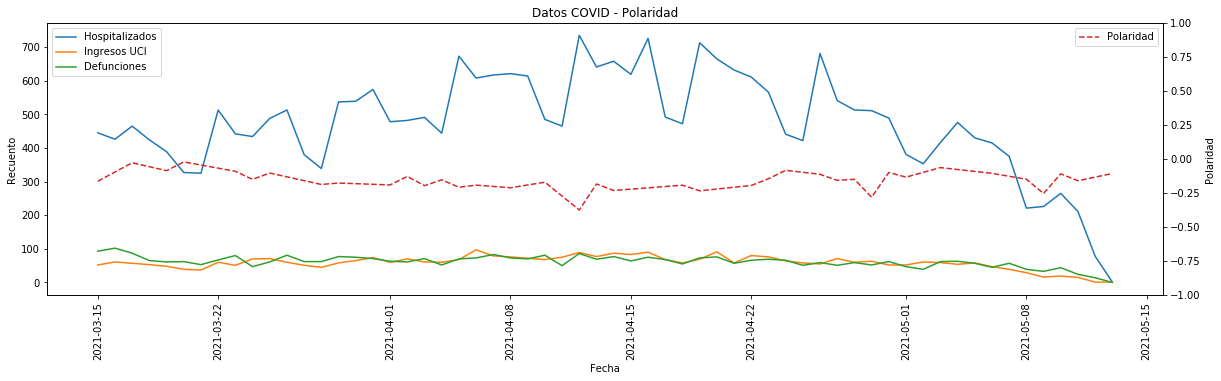

In [20]:
fig, ax1 = plt.subplots(figsize=(20,5))

plt.xticks(rotation=90)

#plt.plot(df_covid_grouped.index, df_covid_grouped['num_casos'], label = "Casos")
ax1.plot(df_covid_grouped.index, df_covid_grouped['num_hosp'], label = "Hospitalizados")
ax1.plot(df_covid_grouped.index, df_covid_grouped['num_uci'], label = "Ingresos UCI")
ax1.plot(df_covid_grouped.index, df_covid_grouped['num_def'], label = "Defunciones")
ax1.set_xlabel('Fecha')
ax1.set_ylabel('Recuento')
ax1.legend(loc=2)

ax2 = ax1.twinx()
color = 'tab:red'
ax2.plot(df_tweets.index, df_tweets['polarity'], label = 'Polaridad', color=color, linestyle= '--')
ax2.set_ylim([-1, 1])
ax2.set_ylabel('Polaridad')
ax2.legend(loc=1)

plt.title('Datos COVID - Polaridad')
plt.legend()

plt.show()

Realizamos un scan de la tabla `tweets_statistics` para descargar todos los datos de la tabla

In [21]:
statistics = tweets_statistics_table.scan()
df_statistics = pd.DataFrame(statistics['Items'])
df_statistics.head()

,neutral,mixed,TweetDate,negative,positive
0,55,17,01/04/2021,22,3
1,76,13,20/03/2021,7,4
2,98,37,05/04/2021,58,6
3,54,17,03/04/2021,26,2
4,71,10,25/03/2021,18,0


In [22]:
df_statistics.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   neutral    60 non-null     object
 1   mixed      60 non-null     object
 2   TweetDate  60 non-null     object
 3   negative   60 non-null     object
 4   positive   60 non-null     object
dtypes: object(5)
memory usage: 2.5+ KB


De igual forma que con la tabla `tweets`, transformamos las columnas numéricas para poder operar con ellas. La columna TweetDate la trasformamos en objeto Datetime.

In [23]:
df_statistics['neutral'] = df_statistics['neutral'].astype(int)
df_statistics['mixed'] = df_statistics['mixed'].astype(int) 
df_statistics['positive'] = df_statistics['positive'].astype(int) 
df_statistics['negative'] = df_statistics['negative'].astype(int) 

df_statistics['TweetDate'] = pd.to_datetime(df_statistics['TweetDate'], format='%d/%m/%Y')

In [24]:
df_statistics.sort_values('TweetDate', inplace=True)

Creamos dos nuevas columnas con el ratio de tweets positivos y negativos con respecto al total de tweets para compararlos con la polaridad obtenida.

In [25]:
df_statistics['positiveRatio'] = df_statistics['positive'] / (df_statistics['positive'] + df_statistics['negative'] + df_statistics['mixed'] + df_statistics['neutral'])
df_statistics['negativeRatio'] = df_statistics['negative'] / (df_statistics['positive'] + df_statistics['negative'] + df_statistics['mixed'] + df_statistics['neutral'])

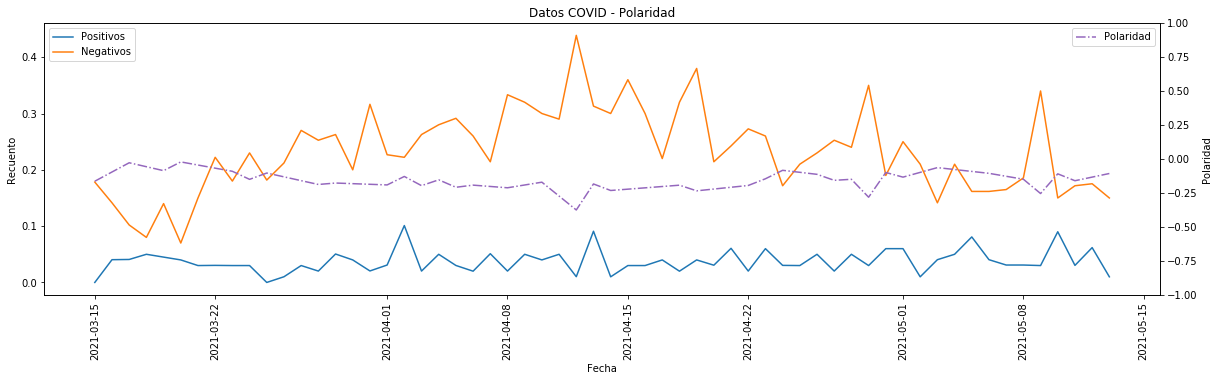

In [26]:
fig, ax1 = plt.subplots(figsize=(20,5))

plt.xticks(rotation=90)

ax1.plot(df_statistics['TweetDate'], df_statistics['positiveRatio'], label = "Positivos")
ax1.plot(df_statistics['TweetDate'], df_statistics['negativeRatio'], label = "Negativos")
ax1.set_xlabel('Fecha')
ax1.set_ylabel('Recuento')
ax1.legend(loc=2)

ax2 = ax1.twinx()
color = 'tab:purple'
ax2.plot(df_tweets.index, df_tweets['polarity'], label = 'Polaridad', color=color, linestyle= '-.')
ax2.set_ylim([-1, 1])
ax2.set_ylabel('Polaridad')
ax2.legend(loc=1)

plt.title('Datos COVID - Polaridad')
plt.show()

####  <font color="#00586D">Conclusiones</font>

Cruzando los datos descargados de la fuente citada junto con los datos de sentimiento y polaridad obtenidos de los servicios implementados en AWS, no se puede establecer a priori la correlación lógica esperada: A una mejora de la situación (disminución de contagios, hospitalizaciones y muertes), una progresión de la polaridad con tendencia a acercarse al valor 1. Esto puede deberse a la cantidad demasiado elevada de tweets clasificados como `neutros` o `mixtos`.

Por otra parte, en la última gráfica vemos cómo la polaridad está por debajo de 0 en todo momento, lo cual es lógico dado el número de tweets negativos que siempre ha superado ampliamente el número de tweets positivos.